
📊 Summary for: FILTERED dataset
--------------------------------------------------
train  ➤ Images: 1671  | Labels: 1671  | Masks: 1671 
val    ➤ Images: 65    | Labels: 65    | Masks: 65   
test   ➤ Images: 32    | Labels: 32    | Masks: 32   

📦 TOTALS:
Images: 1768 | Labels: 1768 | Masks: 1768


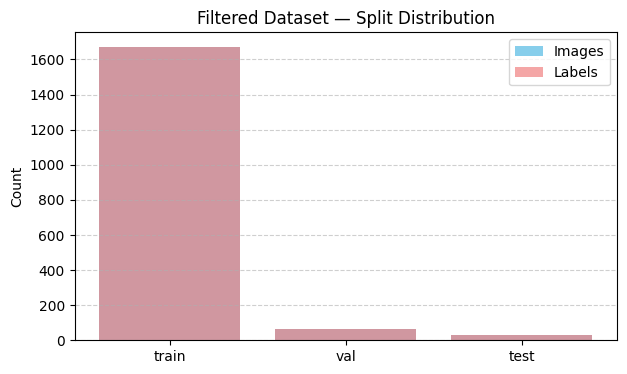


📊 Summary for: AUGMENTED dataset
--------------------------------------------------
train  ➤ Images: 4953  | Labels: 4953  | Masks: 6624 
val    ➤ Images: 195   | Labels: 195   | Masks: 260  
test   ➤ Images: 96    | Labels: 96    | Masks: 128  

📦 TOTALS:
Images: 5244 | Labels: 5244 | Masks: 7012


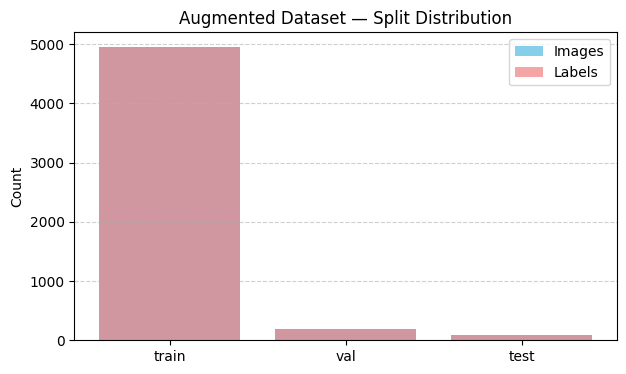

In [ ]:
# ==========================================================
# STEP — Dataset Summary and Visualization
# ==========================================================
import os
import glob
from collections import Counter
import matplotlib.pyplot as plt

base_path = '/content/drive/MyDrive/Dental_Filling_Final'

def count_files(folder, ext):
    return len(glob.glob(os.path.join(folder, f"*.{ext}")))

def summarize_dataset(dataset_type):
    print(f"\n📊 Summary for: {dataset_type.upper()} dataset\n{'-'*50}")
    splits = ['train', 'val', 'test']
    summary = {}
    for split in splits:
        img_path = os.path.join(base_path, dataset_type, 'images', split)
        lbl_path = os.path.join(base_path, dataset_type, 'labels', split)
        mask_path = os.path.join(base_path, dataset_type, 'masks', split)

        imgs = count_files(img_path, 'jpg')
        lbls = count_files(lbl_path, 'txt')
        masks = count_files(mask_path, 'png')

        summary[split] = {'images': imgs, 'labels': lbls, 'masks': masks}

        print(f"{split:<6} ➤ Images: {imgs:<5} | Labels: {lbls:<5} | Masks: {masks:<5}")

    total_imgs = sum(v['images'] for v in summary.values())
    total_lbls = sum(v['labels'] for v in summary.values())
    total_masks = sum(v['masks'] for v in summary.values())

    print("\n📦 TOTALS:")
    print(f"Images: {total_imgs} | Labels: {total_lbls} | Masks: {total_masks}")

    # --- Plot bar chart ---
    splits = list(summary.keys())
    img_counts = [summary[s]['images'] for s in splits]
    lbl_counts = [summary[s]['labels'] for s in splits]

    plt.figure(figsize=(7,4))
    plt.bar(splits, img_counts, color='skyblue', label='Images')
    plt.bar(splits, lbl_counts, color='lightcoral', alpha=0.7, label='Labels')
    plt.title(f"{dataset_type.capitalize()} Dataset — Split Distribution")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    return summary

# --- Summarize filtered and augmented datasets ---
filtered_summary = summarize_dataset('filtered')
augmented_summary = summarize_dataset('augmented')


In [ ]:
# ==========================================================
# STEP 1 — Mount Drive and Setup
# ==========================================================
from google.colab import drive
drive.mount('/content/drive')

import os, cv2, glob, zipfile, shutil
import numpy as np, pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import albumentations as A
import yaml
import random

# ==========================================================
# STEP 2 — Extract ZIP if needed
# ==========================================================
zip_path = '/content/drive/MyDrive/Dataset123.zip'
extract_path = '/content/drive/MyDrive/Dataset123'

if not os.path.exists(extract_path):
    print(" Extracting Dataset123.zip ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/')
    print(" Extraction complete.")
else:
    print(f" Dataset already extracted at {extract_path}")

# ==========================================================
# STEP 3 — Enhanced Processor Class
# ==========================================================
class DentalFillingProcessor:
    def __init__(self):
        self.base_path = '/content/drive/MyDrive/Dataset123/Dataset'
        self.output_base = '/content/drive/MyDrive/Dental_Filling_Final'
        self.splits = ['train', 'val', 'test']

        # Target dataset sizes
        self.target_sizes = {
            'train': 16000,
            'val': 4000,
            'test': 4000
        }

        # --- Load classes from data.yaml dynamically ---
        yaml_path = os.path.join(self.base_path, 'data.yaml')
        with open(yaml_path, 'r') as f:
            data_cfg = yaml.safe_load(f)
        self.class_names = data_cfg.get('names', [])
        print("📘 Classes found:", self.class_names)

        # 🔍 Normalize and detect the Dental Filling class automatically
        normalized_classes = [c.lower().replace("_", " ").strip() for c in self.class_names]
        target_variants = ["dental filling", "dental fillings", "filling", "fillings"]

        self.target_class = None
        for cid, cname in enumerate(normalized_classes):
            if cname in target_variants:
                self.target_class = cid
                break

        if self.target_class is None:
            raise ValueError(f"❌ Could not find a matching 'Dental Filling' class in data.yaml. Found: {self.class_names}")
        else:
            print(f"🎯 Target Class Found → ID {self.target_class}: {self.class_names[self.target_class]}")

        # Mask color (grayscale)
        self.target_gray = 255

        #  Enhanced Albumentations transform with more variations
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
            A.GaussianBlur(blur_limit=3, p=0.2),
            A.RandomGamma(gamma_limit=(80, 120), p=0.2),
            A.ShiftScaleRotate(
                shift_limit=0.15,
                scale_limit=0.15,
                rotate_limit=15,
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                p=0.5
            ),
            A.RandomScale(scale_limit=0.2, p=0.3),
            A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
            A.RandomCrop(height=512, width=512, p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="yolo",
            label_fields=["class_labels"],
            min_visibility=0.3,
            clip=True
        ))

    # -------------------------------------------------------
    def ensure_dir(self, path):
        os.makedirs(path, exist_ok=True)

    # -------------------------------------------------------
    def filter_and_save(self):
        final_base = os.path.join(self.output_base, "filtered")
        for sub in [f"images/{s}" for s in self.splits] + [f"labels/{s}" for s in self.splits] + [f"masks/{s}" for s in self.splits]:
            self.ensure_dir(os.path.join(final_base, sub))

        counts = Counter()
        split_counts = {split: 0 for split in self.splits}
        available_images = {split: [] for split in self.splits}

        # First pass: collect all valid images
        for split in self.splits:
            print(f"\n🔹 Collecting {split} images...")
            img_dir = os.path.join(self.base_path, split, "images")
            lbl_dir = os.path.join(self.base_path, split, "labels")
            imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))

            for img_path in tqdm(imgs, desc=f"{split} collection"):
                base = os.path.splitext(os.path.basename(img_path))[0]
                label_path = os.path.join(lbl_dir, base + ".txt")
                if not os.path.exists(label_path):
                    continue

                img = cv2.imread(img_path)
                if img is None:
                    continue

                # Check if image has dental filling annotations
                has_filling = False
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) >= 5 and int(float(parts[0])) == self.target_class:
                            has_filling = True
                            break

                if has_filling:
                    available_images[split].append((img_path, label_path, base))
                    split_counts[split] += 1

        print(f"\n Original dataset counts:")
        for split in self.splits:
            print(f"   {split}: {split_counts[split]} images with dental fillings")

        return final_base, available_images, split_counts

    # -------------------------------------------------------
    def augment_to_target(self, filtered_base, available_images, original_counts):
        aug_base = os.path.join(self.output_base, "augmented")

        # Create directories
        for split in self.splits:
            for folder in ["images", "labels", "masks"]:
                self.ensure_dir(os.path.join(aug_base, folder, split))

        final_counts = {}

        for split in self.splits:
            print(f"\n Processing {split} to reach {self.target_sizes[split]} images...")

            target_count = self.target_sizes[split]
            current_images = available_images[split].copy()
            random.shuffle(current_images)  # Shuffle for random selection

            images_processed = 0
            augmentation_round = 0

            # Progress bar
            pbar = tqdm(total=target_count, desc=f"{split} generation")

            while images_processed < target_count:
                # If we still have original images, use them first
                if current_images and images_processed < len(available_images[split]):
                    img_path, label_path, base = current_images.pop(0)

                    # Save original
                    self._process_single_image(img_path, label_path, base, aug_base, split, f"orig_{base}")
                    images_processed += 1
                    pbar.update(1)

                else:
                    # Need to augment existing images
                    augmentation_round += 1

                    # Get a random original image for augmentation
                    if not available_images[split]:
                        print(f" No images available for augmentation in {split}")
                        break

                    source_img_path, source_label_path, source_base = random.choice(available_images[split])

                    # Generate multiple augmented versions
                    aug_per_round = min(5, target_count - images_processed)  # Max 5 augmentations per round

                    for aug_idx in range(aug_per_round):
                        if images_processed >= target_count:
                            break

                        try:
                            # Load source image and labels
                            image = cv2.imread(source_img_path)
                            if image is None:
                                continue

                            h, w = image.shape[:2]

                            # Load bounding boxes
                            bboxes, labels = [], []
                            with open(source_label_path, 'r') as f:
                                for line in f.readlines():
                                    parts = line.strip().split()
                                    if len(parts) >= 5 and int(float(parts[0])) == self.target_class:
                                        cls, x, y, bw, bh = map(float, parts[:5])
                                        bboxes.append([x, y, bw, bh])
                                        labels.append(0)  # Remap to single class

                            if not bboxes:
                                continue

                            # Apply augmentation
                            transformed = self.transform(
                                image=image,
                                bboxes=bboxes,
                                class_labels=labels
                            )

                            aug_img = transformed['image']
                            aug_boxes = transformed['bboxes']

                            if aug_boxes:
                                # Save augmented image
                                aug_name = f"aug{augmentation_round}_{source_base}_v{aug_idx}"
                                self._save_augmented_image(
                                    aug_img, aug_boxes, aug_name,
                                    aug_base, split, source_label_path
                                )
                                images_processed += 1
                                pbar.update(1)

                        except Exception as e:
                            print(f"⚠️ Augmentation error: {e}")
                            continue

            pbar.close()
            final_counts[split] = images_processed
            print(f" {split}: Generated {images_processed} images")

        return aug_base, final_counts

    # -------------------------------------------------------
    def _process_single_image(self, img_path, label_path, base, output_base, split, name_prefix):
        """Process and save a single image with its label and mask"""
        # Copy image
        dst_img = os.path.join(output_base, "images", split, f"{name_prefix}.jpg")
        shutil.copyfile(img_path, dst_img)

        # Process and save label (convert to single class)
        dst_lbl = os.path.join(output_base, "labels", split, f"{name_prefix}.txt")
        self._convert_labels(label_path, dst_lbl)

        # Generate and save mask
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        dst_mask = os.path.join(output_base, "masks", split, f"{name_prefix}.png")
        self._generate_mask(label_path, dst_mask, h, w)

    # -------------------------------------------------------
    def _save_augmented_image(self, image, bboxes, aug_name, output_base, split, original_label_path):
        """Save augmented image with its label and mask"""
        # Save augmented image
        img_path = os.path.join(output_base, "images", split, f"{aug_name}.jpg")
        cv2.imwrite(img_path, image)

        h, w = image.shape[:2]

        # Save augmented label
        lbl_path = os.path.join(output_base, "labels", split, f"{aug_name}.txt")
        with open(lbl_path, 'w') as f:
            for bbox in bboxes:
                x, y, bw, bh = bbox
                f.write(f"0 {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

        # Generate and save augmented mask
        mask_path = os.path.join(output_base, "masks", split, f"{aug_name}.png")
        mask = np.zeros((h, w), dtype=np.uint8)
        for x, y, bw, bh in bboxes:
            x1, y1 = int((x - bw/2) * w), int((y - bh/2) * h)
            x2, y2 = int((x + bw/2) * w), int((y + bh/2) * h)
            # Ensure coordinates are within bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w-1, x2), min(h-1, y2)
            cv2.rectangle(mask, (x1, y1), (x2, y2), self.target_gray, -1)
        cv2.imwrite(mask_path, mask)

    # -------------------------------------------------------
    def _convert_labels(self, source_label_path, dest_label_path):
        """Convert multi-class labels to single-class (dental filling only)"""
        with open(source_label_path, 'r') as f_in, open(dest_label_path, 'w') as f_out:
            for line in f_in.readlines():
                parts = line.strip().split()
                if len(parts) >= 5 and int(float(parts[0])) == self.target_class:
                    # Convert to single class (0) for dental filling
                    f_out.write(f"0 {parts[1]} {parts[2]} {parts[3]} {parts[4]}\n")

    # -------------------------------------------------------
    def _generate_mask(self, label_path, mask_path, height, width):
        """Generate segmentation mask from YOLO labels"""
        mask = np.zeros((height, width), dtype=np.uint8)

        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) >= 5 and int(float(parts[0])) == self.target_class:
                    _, x, y, bw, bh = map(float, parts[:5])
                    x1 = int((x - bw/2) * width)
                    y1 = int((y - bh/2) * height)
                    x2 = int((x + bw/2) * width)
                    y2 = int((y + bh/2) * height)
                    # Ensure coordinates are within bounds
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(width-1, x2), min(height-1, y2)
                    cv2.rectangle(mask, (x1, y1), (x2, y2), self.target_gray, -1)

        cv2.imwrite(mask_path, mask)

    # -------------------------------------------------------
    def create_dataset_yaml(self, output_path):
        """Create data.yaml file for YOLO training"""
        data = {
            'path': output_path,
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'nc': 1,  # single class
            'names': ['dental_filling']
        }

        yaml_path = os.path.join(output_path, 'data.yaml')
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)

        print(f" Created dataset config: {yaml_path}")
        return yaml_path

    # -------------------------------------------------------
    def summary(self, original_counts, final_counts):
        """Display dataset statistics"""
        print("\n" + "="*50)
        print(" DATASET GENERATION SUMMARY")
        print("="*50)

        print("\n Counts Comparison:")
        print(f"{'Split':<10} {'Original':<10} {'Target':<10} {'Final':<10} {'Status':<10}")
        print("-" * 50)

        for split in self.splits:
            original = original_counts[split]
            target = self.target_sizes[split]
            final = final_counts[split]
            status = " ACHIEVED" if final >= target else " INCOMPLETE"
            print(f"{split:<10} {original:<10} {target:<10} {final:<10} {status:<10}")

        # Plot comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Bar chart
        splits = list(self.splits)
        original_vals = [original_counts[s] for s in splits]
        final_vals = [final_counts[s] for s in splits]
        target_vals = [self.target_sizes[s] for s in splits]

        x = np.arange(len(splits))
        width = 0.25

        ax1.bar(x - width, original_vals, width, label='Original', alpha=0.7)
        ax1.bar(x, final_vals, width, label='Final', alpha=0.7)
        ax1.bar(x + width, target_vals, width, label='Target', alpha=0.7)
        ax1.set_xlabel('Dataset Split')
        ax1.set_ylabel('Number of Images')
        ax1.set_title('Dataset Size Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(splits)
        ax1.legend()

        # Pie chart for final distribution
        ax2.pie(final_vals, labels=splits, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Final Dataset Distribution')

        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------
    def run_pipeline(self):
        """Main pipeline execution"""
        print(" Starting Dental Filling Dataset Generation Pipeline...")

        # Step 1: Filter and collect available images
        filtered_base, available_images, original_counts = self.filter_and_save()

        # Step 2: Augment to target sizes
        aug_base, final_counts = self.augment_to_target(filtered_base, available_images, original_counts)

        # Step 3: Create YOLO dataset configuration
        self.create_dataset_yaml(aug_base)

        # Step 4: Display summary
        self.summary(original_counts, final_counts)

        print("\n PIPELINE COMPLETED SUCCESSFULLY!")
        print(f" Final dataset location: {aug_base}")
        print(f" Final counts: {final_counts}")

# ==========================================================
# STEP 4 — Run the Enhanced Pipeline
# ==========================================================
processor = DentalFillingProcessor()
processor.run_pipeline()

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# ==========================================================
# INSTALL AND IMPORT DEPENDENCIES
# ==========================================================
!pip install ultralytics --quiet

import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Verify installation
from ultralytics import checks
checks()


Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.8/235.7 GB disk)


In [ ]:
from ultralytics import YOLO

# Create output directory
det_output = "/content/drive/MyDrive/yolov8_detection"
os.makedirs(det_output, exist_ok=True)

# Initialize detection model
det_model = YOLO('yolov8s.pt')  # You can use yolov8m.pt for higher accuracy

# Train for detection
det_model.train(
    data='/content/drive/MyDrive/Dental_Filling_Final/augmented/data.yaml',
    epochs=100,
    imgsz=512,
    batch=16,
    project=det_output,
    name='exp',
    patience=15,
    optimizer='Adam',
    workers=4
)


Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Dental_Filling_Final/augmented/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, pa

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fd27a3587a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
!ls -lh /content/drive/MyDrive/yolov8_detection/exp/weights


total 43M
-rw------- 1 root root 22M Oct  9 00:45 best.pt
-rw------- 1 root root 22M Oct  9 00:45 last.pt


In [ ]:
from ultralytics import YOLO

det_model = YOLO("/content/drive/MyDrive/yolov8_detection/exp/weights/best.pt")


In [ ]:
import shutil

# Define paths
src_best = "/content/drive/MyDrive/yolov8_detection/exp/weights/best.pt"
src_last = "/content/drive/MyDrive/yolov8_detection/exp/weights/last.pt"
dst_dir = "/content/drive/MyDrive/yolov8_detection"

# Copy to top-level directory
shutil.copy(src_best, f"{dst_dir}/best.pt")
shutil.copy(src_last, f"{dst_dir}/last.pt")

print("✅ Models successfully copied to:", dst_dir)


✅ Models successfully copied to: /content/drive/MyDrive/yolov8_detection


In [ ]:
from ultralytics import YOLO
import os

# Create segmentation output folder
seg_output = "/content/drive/MyDrive/yolov8_segmentation"
os.makedirs(seg_output, exist_ok=True)

# Initialize segmentation model
seg_model = YOLO('yolov8s-seg.pt')  # You can try yolov8m-seg.pt for higher accuracy

# Train for segmentation
seg_model.train(
    data='/content/drive/MyDrive/Dental_Filling_Final/augmented/data.yaml',
    epochs=400,
    imgsz=512,
    batch=8,
    project=seg_output,
    name='exp',
    patience=20,
    optimizer='Adam',
    workers=4
)


Ultralytics 8.3.207 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Dental_Filling_Final/augmented/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=400, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True,

TypeError: ERROR ❌ segment dataset incorrectly formatted or not a segment dataset.
This error can occur when incorrectly training a 'segment' model on a 'detect' dataset, i.e. 'yolo train model=yolo11n-seg.pt data=coco8.yaml'.
Verify your dataset is a correctly formatted 'segment' dataset using 'data=coco8-seg.yaml' as an example.
See https://docs.ultralytics.com/datasets/segment/ for help.

**This is New Version **

Mounted at /content/drive
 Dataset already extracted at /content/drive/MyDrive/Dataset123
📘 Classes found: ['Crown', 'Dental_Fillings', 'Endodontic_post', 'Root_Canal_treated_tooth', 'bridge', 'implant']
🎯 Target Class Found → ID 1: Dental_Fillings
 Starting Dental Filling Dataset Generation Pipeline...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-647115771.py:77: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-647115771.py:87: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),



🔹 Collecting train images...


train collection: 100%|██████████| 2235/2235 [23:39<00:00,  1.57it/s]



🔹 Collecting val images...


val collection: 100%|██████████| 80/80 [01:48<00:00,  1.36s/it]



🔹 Collecting test images...


test collection: 100%|██████████| 41/41 [00:50<00:00,  1.23s/it]



 Original dataset counts:
   train: 1671 images with dental fillings
   val: 65 images with dental fillings
   test: 32 images with dental fillings

 Processing train to reach 16000 images...


train generation: 100%|██████████| 16000/16000 [48:36<00:00,  5.49it/s]


 train: Generated 16000 images

 Processing val to reach 4000 images...


val generation: 100%|██████████| 4000/4000 [04:00<00:00, 16.62it/s]


 val: Generated 4000 images

 Processing test to reach 4000 images...


test generation: 100%|██████████| 4000/4000 [03:37<00:00, 18.36it/s]


 test: Generated 4000 images
 Created dataset config: /content/drive/MyDrive/Dental_Filling_Final/augmented/data.yaml

 Visualizing 5 samples...

TRAIN split samples:


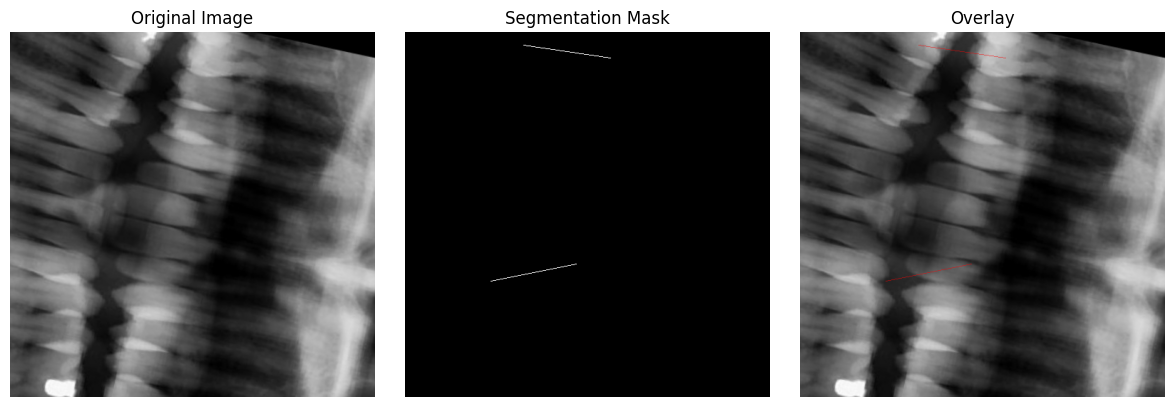


VAL split samples:


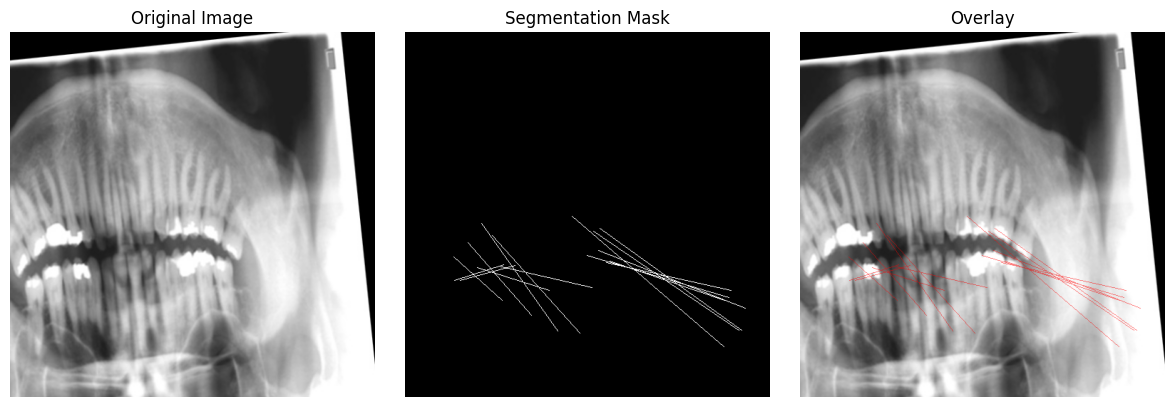


TEST split samples:


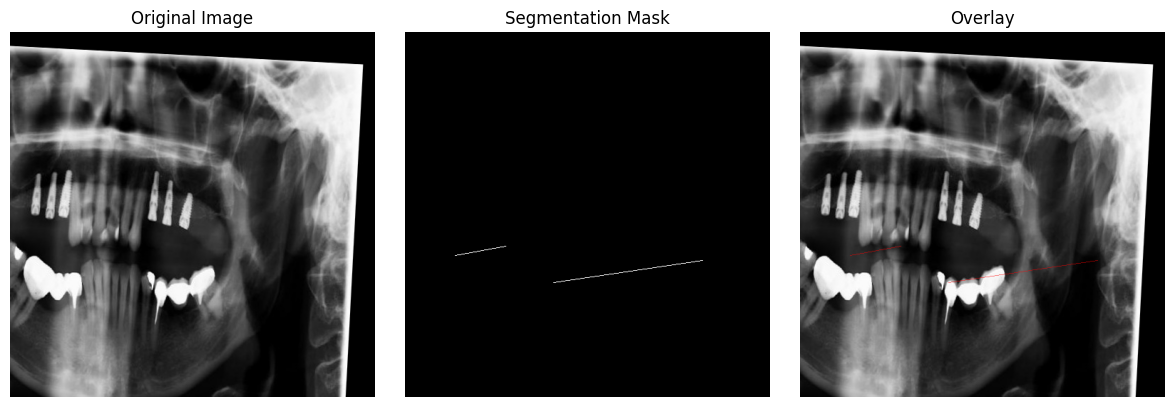


 DATASET GENERATION SUMMARY

 Counts Comparison:
Split      Original   Target     Final      Status    
--------------------------------------------------
train      1671       16000      16000       ACHIEVED 
val        65         4000       4000        ACHIEVED 
test       32         4000       4000        ACHIEVED 


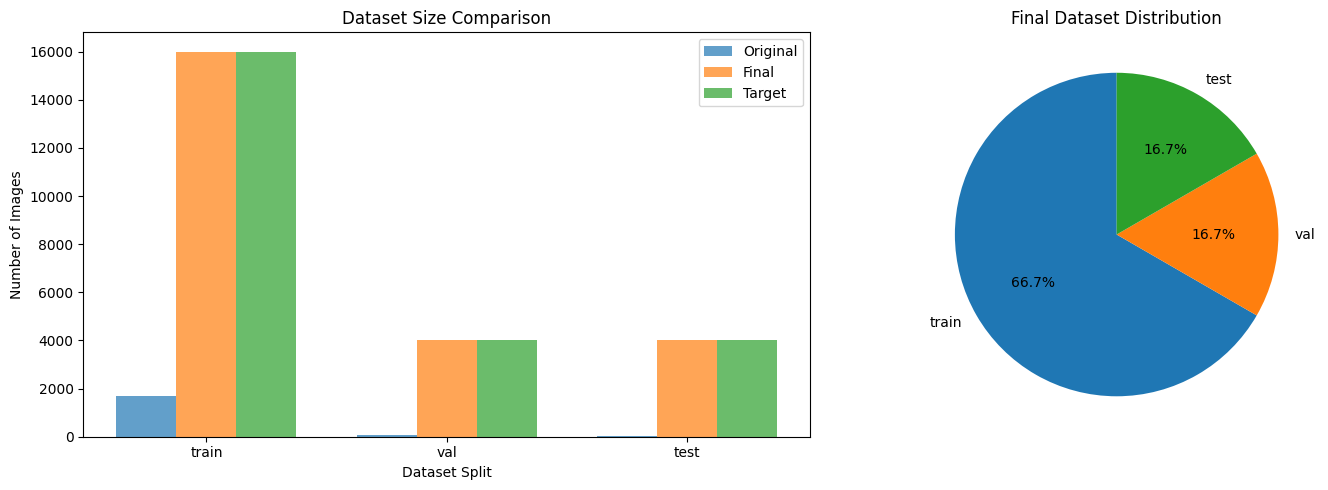


 PIPELINE COMPLETED SUCCESSFULLY!
 Final dataset location: /content/drive/MyDrive/Dental_Filling_Final/augmented
 Final counts: {'train': 16000, 'val': 4000, 'test': 4000}

 Dataset structure:
 /content/drive/MyDrive/Dental_Filling_Final/augmented/
 ├── data.yaml
 ├── images/
 │   ├── train/
 │   ├── val/
 │   └── test/
 └── labels/
     ├── train/
     ├── val/
     └── test/


In [ ]:
# ==========================================================
# STEP 1 — Mount Drive and Setup
# ==========================================================
from google.colab import drive
drive.mount('/content/drive')

import os, cv2, glob, zipfile, shutil
import numpy as np, pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import albumentations as A
import yaml
import random
from skimage import measure

# ==========================================================
# STEP 2 — Extract ZIP if needed
# ==========================================================
zip_path = '/content/drive/MyDrive/Dataset123.zip'
extract_path = '/content/drive/MyDrive/Dataset123'

if not os.path.exists(extract_path):
    print(" Extracting Dataset123.zip ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/')
    print(" Extraction complete.")
else:
    print(f" Dataset already extracted at {extract_path}")

# ==========================================================
# STEP 3 — Enhanced Processor Class for YOLO Segmentation
# ==========================================================
class DentalFillingProcessor:
    def __init__(self):
        self.base_path = '/content/drive/MyDrive/Dataset123/Dataset'
        self.output_base = '/content/drive/MyDrive/Dental_Filling_Final'
        self.splits = ['train', 'val', 'test']

        # Target dataset sizes
        self.target_sizes = {
            'train': 16000,
            'val': 4000,
            'test': 4000
        }

        # --- Load classes from data.yaml dynamically ---
        yaml_path = os.path.join(self.base_path, 'data.yaml')
        with open(yaml_path, 'r') as f:
            data_cfg = yaml.safe_load(f)
        self.class_names = data_cfg.get('names', [])
        print("📘 Classes found:", self.class_names)

        # 🔍 Normalize and detect the Dental Filling class automatically
        normalized_classes = [c.lower().replace("_", " ").strip() for c in self.class_names]
        target_variants = ["dental filling", "dental fillings", "filling", "fillings"]

        self.target_class = None
        for cid, cname in enumerate(normalized_classes):
            if cname in target_variants:
                self.target_class = cid
                break

        if self.target_class is None:
            raise ValueError(f"❌ Could not find a matching 'Dental Filling' class in data.yaml. Found: {self.class_names}")
        else:
            print(f"🎯 Target Class Found → ID {self.target_class}: {self.class_names[self.target_class]}")

        # Enhanced Albumentations transform for segmentation
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
            A.GaussianBlur(blur_limit=3, p=0.2),
            A.RandomGamma(gamma_limit=(80, 120), p=0.2),
            A.ShiftScaleRotate(
                shift_limit=0.15,
                scale_limit=0.15,
                rotate_limit=15,
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                mask_value=0,
                p=0.5
            ),
            A.RandomScale(scale_limit=0.2, p=0.3),
            A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
            A.RandomCrop(height=512, width=512, p=1.0),
        ])

    # -------------------------------------------------------
    def ensure_dir(self, path):
        os.makedirs(path, exist_ok=True)

    # -------------------------------------------------------
    def create_segmentation_mask_from_bbox(self, label_path, image_height, image_width):
        """Create segmentation mask from bounding box annotations"""
        mask = np.zeros((image_height, image_width), dtype=np.uint8)

        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) >= 5 and int(float(parts[0])) == self.target_class:
                    _, x_center, y_center, width, height = map(float, parts[:5])

                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * image_width)
                    y1 = int((y_center - height/2) * image_height)
                    x2 = int((x_center + width/2) * image_width)
                    y2 = int((y_center + height/2) * image_height)

                    # Ensure coordinates are within bounds
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(image_width-1, x2), min(image_height-1, y2)

                    # Create filled rectangle as segmentation mask
                    cv2.rectangle(mask, (x1, y1), (x2, y2), 1, -1)

        return mask

    # -------------------------------------------------------
    def mask_to_yolo_segmentation(self, mask):
        """Convert binary mask to YOLO segmentation format"""
        # Find contours in the mask
        contours = measure.find_contours(mask, 0.5)

        segmentation_points = []
        for contour in contours:
            # Simplify contour (reduce points)
            epsilon = 0.002 * cv2.arcLength(contour.astype(np.float32), True)
            approx = cv2.approxPolyDP(contour.astype(np.float32), epsilon, True)

            if len(approx) >= 3:  # Need at least 3 points for a polygon
                # Normalize coordinates
                normalized_points = []
                for point in approx:
                    x = point[0][0] / mask.shape[1]  # Normalize x
                    y = point[0][1] / mask.shape[0]  # Normalize y
                    # Ensure coordinates are within [0,1]
                    x = max(0, min(1, x))
                    y = max(0, min(1, y))
                    normalized_points.extend([x, y])

                segmentation_points.append(normalized_points)

        return segmentation_points

    # -------------------------------------------------------
    def filter_and_save(self):
        final_base = os.path.join(self.output_base, "filtered")
        for sub in [f"images/{s}" for s in self.splits] + [f"labels/{s}" for s in self.splits]:
            self.ensure_dir(os.path.join(final_base, sub))

        counts = Counter()
        split_counts = {split: 0 for split in self.splits}
        available_images = {split: [] for split in self.splits}

        # First pass: collect all valid images
        for split in self.splits:
            print(f"\n🔹 Collecting {split} images...")
            img_dir = os.path.join(self.base_path, split, "images")
            lbl_dir = os.path.join(self.base_path, split, "labels")
            imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))

            for img_path in tqdm(imgs, desc=f"{split} collection"):
                base = os.path.splitext(os.path.basename(img_path))[0]
                label_path = os.path.join(lbl_dir, base + ".txt")
                if not os.path.exists(label_path):
                    continue

                img = cv2.imread(img_path)
                if img is None:
                    continue

                # Check if image has dental filling annotations
                has_filling = False
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) >= 5 and int(float(parts[0])) == self.target_class:
                            has_filling = True
                            break

                if has_filling:
                    available_images[split].append((img_path, label_path, base))
                    split_counts[split] += 1

        print(f"\n Original dataset counts:")
        for split in self.splits:
            print(f"   {split}: {split_counts[split]} images with dental fillings")

        return final_base, available_images, split_counts

    # -------------------------------------------------------
    def augment_to_target(self, filtered_base, available_images, original_counts):
        aug_base = os.path.join(self.output_base, "augmented")

        # Create directories
        for split in self.splits:
            for folder in ["images", "labels"]:
                self.ensure_dir(os.path.join(aug_base, folder, split))

        final_counts = {}

        for split in self.splits:
            print(f"\n Processing {split} to reach {self.target_sizes[split]} images...")

            target_count = self.target_sizes[split]
            current_images = available_images[split].copy()
            random.shuffle(current_images)

            images_processed = 0
            augmentation_round = 0

            # Progress bar
            pbar = tqdm(total=target_count, desc=f"{split} generation")

            while images_processed < target_count:
                # If we still have original images, use them first
                if current_images and images_processed < len(available_images[split]):
                    img_path, label_path, base = current_images.pop(0)

                    # Save original
                    self._process_single_image(img_path, label_path, base, aug_base, split, f"orig_{base}")
                    images_processed += 1
                    pbar.update(1)

                else:
                    # Need to augment existing images
                    augmentation_round += 1

                    # Get a random original image for augmentation
                    if not available_images[split]:
                        print(f" No images available for augmentation in {split}")
                        break

                    source_img_path, source_label_path, source_base = random.choice(available_images[split])

                    # Generate multiple augmented versions
                    aug_per_round = min(5, target_count - images_processed)

                    for aug_idx in range(aug_per_round):
                        if images_processed >= target_count:
                            break

                        try:
                            # Load source image and create mask
                            image = cv2.imread(source_img_path)
                            if image is None:
                                continue

                            h, w = image.shape[:2]
                            mask = self.create_segmentation_mask_from_bbox(source_label_path, h, w)

                            # Apply augmentation to both image and mask
                            transformed = self.transform(
                                image=image,
                                mask=mask
                            )

                            aug_img = transformed['image']
                            aug_mask = transformed['mask']

                            # Convert augmented mask to YOLO segmentation format
                            segmentation_points = self.mask_to_yolo_segmentation(aug_mask)

                            if segmentation_points:  # Only save if we have valid segments
                                aug_name = f"aug{augmentation_round}_{source_base}_v{aug_idx}"

                                # Save augmented image
                                img_save_path = os.path.join(aug_base, "images", split, f"{aug_name}.jpg")
                                cv2.imwrite(img_save_path, aug_img)

                                # Save YOLO segmentation labels
                                lbl_save_path = os.path.join(aug_base, "labels", split, f"{aug_name}.txt")
                                with open(lbl_save_path, 'w') as f:
                                    for segment in segmentation_points:
                                        line = "0 " + " ".join([f"{coord:.6f}" for coord in segment])
                                        f.write(line + "\n")

                                images_processed += 1
                                pbar.update(1)

                        except Exception as e:
                            print(f"⚠️ Augmentation error: {e}")
                            continue

            pbar.close()
            final_counts[split] = images_processed
            print(f" {split}: Generated {images_processed} images")

        return aug_base, final_counts

    # -------------------------------------------------------
    def _process_single_image(self, img_path, label_path, base, output_base, split, name_prefix):
        """Process and save a single image with YOLO segmentation labels"""
        # Copy image
        dst_img = os.path.join(output_base, "images", split, f"{name_prefix}.jpg")
        shutil.copyfile(img_path, dst_img)

        # Create and save YOLO segmentation labels
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        mask = self.create_segmentation_mask_from_bbox(label_path, h, w)
        segmentation_points = self.mask_to_yolo_segmentation(mask)

        dst_lbl = os.path.join(output_base, "labels", split, f"{name_prefix}.txt")
        with open(dst_lbl, 'w') as f:
            for segment in segmentation_points:
                line = "0 " + " ".join([f"{coord:.6f}" for coord in segment])
                f.write(line + "\n")

    # -------------------------------------------------------
    def create_dataset_yaml(self, output_path):
        """Create data.yaml file for YOLO segmentation training"""
        data = {
            'path': output_path,
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'nc': 1,  # single class
            'names': ['dental_filling']
        }

        yaml_path = os.path.join(output_path, 'data.yaml')
        with open(yaml_path, 'w') as f:
            yaml.dump(data, f, default_flow_style=False)

        print(f" Created dataset config: {yaml_path}")
        return yaml_path

    # -------------------------------------------------------
    def visualize_samples(self, output_path, num_samples=5):
        """Visualize some samples to verify segmentation masks"""
        print(f"\n Visualizing {num_samples} samples...")

        for split in self.splits:
            print(f"\n{split.upper()} split samples:")
            img_dir = os.path.join(output_path, "images", split)
            lbl_dir = os.path.join(output_path, "labels", split)

            images = glob.glob(os.path.join(img_dir, "*.jpg"))[:num_samples]

            for img_path in images:
                base = os.path.splitext(os.path.basename(img_path))[0]
                lbl_path = os.path.join(lbl_dir, base + ".txt")

                if not os.path.exists(lbl_path):
                    continue

                # Load image
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                h, w = img.shape[:2]

                # Create mask from segmentation points
                mask = np.zeros((h, w), dtype=np.uint8)
                with open(lbl_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) > 1 and parts[0] == '0':
                            points = list(map(float, parts[1:]))
                            # Convert normalized points to pixel coordinates
                            pixel_points = []
                            for i in range(0, len(points), 2):
                                x = int(points[i] * w)
                                y = int(points[i+1] * h)
                                pixel_points.append([x, y])

                            if pixel_points:
                                contour = np.array(pixel_points, dtype=np.int32)
                                cv2.fillPoly(mask, [contour], 1)

                # Overlay mask on image
                overlay = img_rgb.copy()
                overlay[mask == 1] = [255, 0, 0]  # Red color for mask

                # Blend
                alpha = 0.5
                blended = cv2.addWeighted(img_rgb, 1 - alpha, overlay, alpha, 0)

                # Display
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(img_rgb)
                plt.title("Original Image")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap='gray')
                plt.title("Segmentation Mask")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(blended)
                plt.title("Overlay")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
                break  # Show only one per split for brevity

    # -------------------------------------------------------
    def summary(self, original_counts, final_counts):
        """Display dataset statistics"""
        print("\n" + "="*50)
        print(" DATASET GENERATION SUMMARY")
        print("="*50)

        print("\n Counts Comparison:")
        print(f"{'Split':<10} {'Original':<10} {'Target':<10} {'Final':<10} {'Status':<10}")
        print("-" * 50)

        for split in self.splits:
            original = original_counts[split]
            target = self.target_sizes[split]
            final = final_counts[split]
            status = " ACHIEVED" if final >= target else " INCOMPLETE"
            print(f"{split:<10} {original:<10} {target:<10} {final:<10} {status:<10}")

        # Plot comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Bar chart
        splits = list(self.splits)
        original_vals = [original_counts[s] for s in splits]
        final_vals = [final_counts[s] for s in splits]
        target_vals = [self.target_sizes[s] for s in splits]

        x = np.arange(len(splits))
        width = 0.25

        ax1.bar(x - width, original_vals, width, label='Original', alpha=0.7)
        ax1.bar(x, final_vals, width, label='Final', alpha=0.7)
        ax1.bar(x + width, target_vals, width, label='Target', alpha=0.7)
        ax1.set_xlabel('Dataset Split')
        ax1.set_ylabel('Number of Images')
        ax1.set_title('Dataset Size Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(splits)
        ax1.legend()

        # Pie chart for final distribution
        ax2.pie(final_vals, labels=splits, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Final Dataset Distribution')

        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------
    def run_pipeline(self):
        """Main pipeline execution"""
        print(" Starting Dental Filling Dataset Generation Pipeline...")

        # Step 1: Filter and collect available images
        filtered_base, available_images, original_counts = self.filter_and_save()

        # Step 2: Augment to target sizes
        aug_base, final_counts = self.augment_to_target(filtered_base, available_images, original_counts)

        # Step 3: Create YOLO dataset configuration
        self.create_dataset_yaml(aug_base)

        # Step 4: Visualize samples
        self.visualize_samples(aug_base)

        # Step 5: Display summary
        self.summary(original_counts, final_counts)

        print("\n PIPELINE COMPLETED SUCCESSFULLY!")
        print(f" Final dataset location: {aug_base}")
        print(f" Final counts: {final_counts}")
        print(f"\n Dataset structure:")
        print(f" {aug_base}/")
        print(f" ├── data.yaml")
        print(f" ├── images/")
        print(f" │   ├── train/")
        print(f" │   ├── val/")
        print(f" │   └── test/")
        print(f" └── labels/")
        print(f"     ├── train/")
        print(f"     ├── val/")
        print(f"     └── test/")

# ==========================================================
# STEP 4 — Run the Enhanced Pipeline
# ==========================================================
processor = DentalFillingProcessor()
processor.run_pipeline()

🚀 YOLOv11 Segmentation Trainer Initialized
📁 Dataset path: /content/drive/MyDrive/Dental_Filling_Final/augmented_fixed
💾 Output directory: /content/drive/MyDrive/YOLOv11_Dental_Results_Seg
🚀 Starting Complete YOLOv11 Segmentation Pipeline...
🔄 Step 0: Fixing dataset format...
🔄 Fixing dataset format for segmentation...
🔧 Processing train split...


100%|██████████| 23282/23282 [05:25<00:00, 71.52it/s] 


🔧 Processing val split...


100%|██████████| 6110/6110 [01:22<00:00, 74.47it/s] 


🔧 Processing test split...


100%|██████████| 5365/5365 [02:05<00:00, 42.90it/s] 


Streaming output truncated to the last 5000 lines.
image 412/5366 /content/drive/MyDrive/Dental_Filling_Final/augmented_fixed/images/test/aug12_33_JPG.rf.0c78a76637cac94a58f669e33536d53e_v0.jpg: 640x640 (no detections), 11.2ms
image 413/5366 /content/drive/MyDrive/Dental_Filling_Final/augmented_fixed/images/test/aug12_33_JPG.rf.0c78a76637cac94a58f669e33536d53e_v1.jpg: 640x640 (no detections), 12.0ms
image 414/5366 /content/drive/MyDrive/Dental_Filling_Final/augmented_fixed/images/test/aug12_33_JPG.rf.0c78a76637cac94a58f669e33536d53e_v2.jpg: 640x640 (no detections), 11.5ms
image 415/5366 /content/drive/MyDrive/Dental_Filling_Final/augmented_fixed/images/test/aug12_33_JPG.rf.0c78a76637cac94a58f669e33536d53e_v3.jpg: 640x640 (no detections), 11.4ms
image 416/5366 /content/drive/MyDrive/Dental_Filling_Final/augmented_fixed/images/test/aug12_33_JPG.rf.0c78a76637cac94a58f669e33536d53e_v4.jpg: 640x640 (no detections), 14.5ms
image 417/5366 /content/drive/MyDrive/Dental_Filling_Final/augmented_

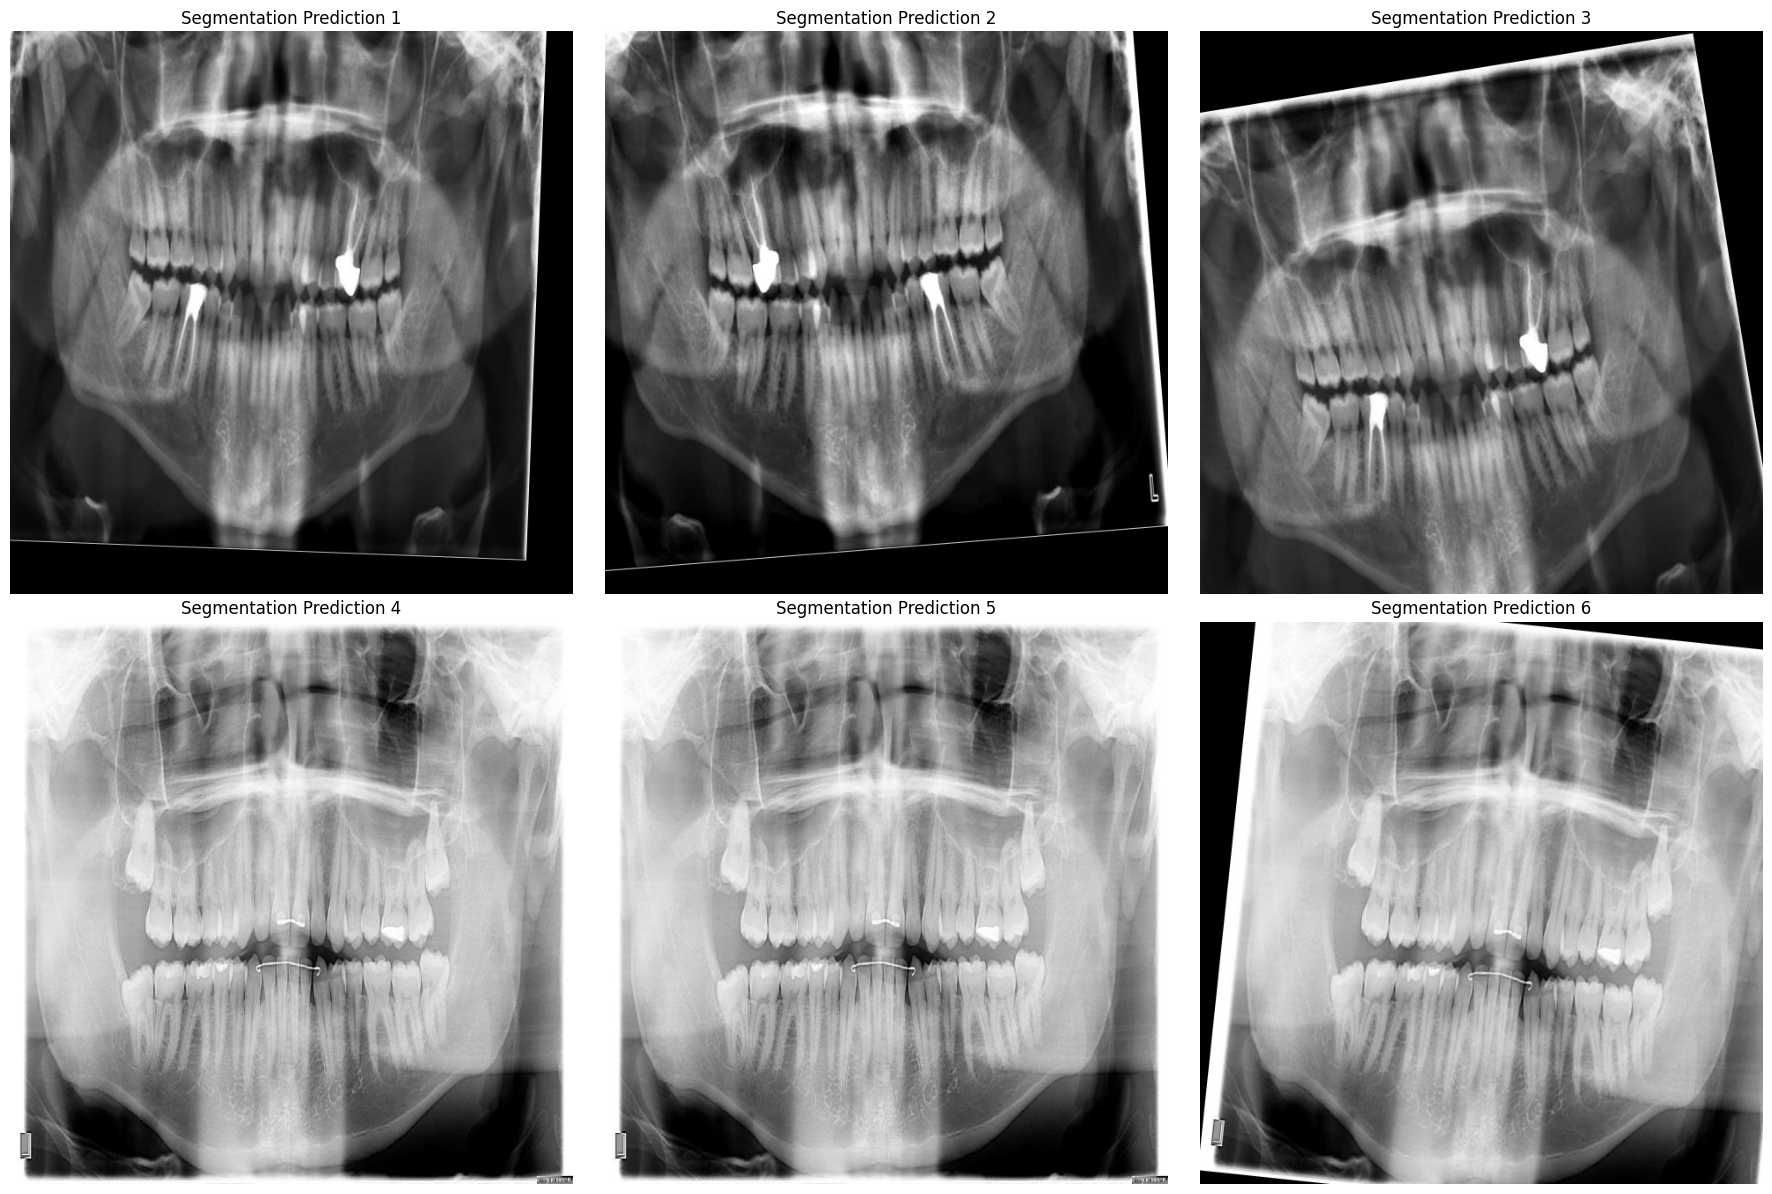


🎉 YOLOv11 DENTAL FILLING SEGMENTATION COMPLETED!
📁 All results saved in: /content/drive/MyDrive/YOLOv11_Dental_Results_Seg/
🔍 Check the segmentation results in /research_paper_results/
📄 Research report: segmentation_research_report.md


In [ ]:
# ==========================================================
# STEP 1 — Fix Dataset Format for Segmentation
# ==========================================================

import os
import cv2
import glob
import shutil
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import torch
from tqdm import tqdm

# ==========================================================
# STEP 2 — Dataset Format Fixer
# ==========================================================
class DatasetFormatFixer:
    def __init__(self):
        self.dataset_path = '/content/drive/MyDrive/Dental_Filling_Final/augmented'
        self.fixed_dataset_path = '/content/drive/MyDrive/Dental_Filling_Final/augmented_fixed'

    def fix_dataset_format(self):
        """Convert detection dataset to proper segmentation format"""
        print("🔄 Fixing dataset format for segmentation...")

        # Create fixed dataset directory structure
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(self.fixed_dataset_path, 'images', split), exist_ok=True)
            os.makedirs(os.path.join(self.fixed_dataset_path, 'labels', split), exist_ok=True)

        # Copy images and fix labels for each split
        for split in ['train', 'val', 'test']:
            print(f"🔧 Processing {split} split...")

            # Copy images
            src_img_dir = os.path.join(self.dataset_path, 'images', split)
            dst_img_dir = os.path.join(self.fixed_dataset_path, 'images', split)

            if os.path.exists(src_img_dir):
                for img_file in tqdm(os.listdir(src_img_dir)):
                    if img_file.endswith('.jpg'):
                        src_path = os.path.join(src_img_dir, img_file)
                        dst_path = os.path.join(dst_img_dir, img_file)
                        shutil.copy2(src_path, dst_path)

            # Fix labels - convert bounding boxes to segmentation polygons
            src_lbl_dir = os.path.join(self.dataset_path, 'labels', split)
            dst_lbl_dir = os.path.join(self.fixed_dataset_path, 'labels', split)

            if os.path.exists(src_lbl_dir):
                for lbl_file in tqdm(os.listdir(src_lbl_dir)):
                    if lbl_file.endswith('.txt'):
                        self._convert_bbox_to_segmentation(
                            os.path.join(src_lbl_dir, lbl_file),
                            os.path.join(dst_lbl_dir, lbl_file)
                        )

        # Create fixed data.yaml
        self._create_fixed_data_yaml()
        print("✅ Dataset format fixed successfully!")

    def _convert_bbox_to_segmentation(self, src_label_path, dst_label_path):
        """Convert bounding box labels to segmentation polygon labels"""
        if not os.path.exists(src_label_path):
            return

        with open(src_label_path, 'r') as f:
            lines = f.readlines()

        segmentation_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:  # At least class + bbox coordinates
                class_id = parts[0]
                x_center, y_center, width, height = map(float, parts[1:5])

                # Convert bbox to polygon (rectangle)
                x1 = x_center - width/2
                y1 = y_center - height/2
                x2 = x_center + width/2
                y2 = y_center - height/2
                x3 = x_center + width/2
                y3 = y_center + height/2
                x4 = x_center - width/2
                y4 = y_center + height/2

                # Create polygon points (normalized)
                polygon_points = [
                    x1, y1,  # top-left
                    x2, y2,  # top-right
                    x3, y3,  # bottom-right
                    x4, y4   # bottom-left
                ]

                # Ensure all points are within [0, 1]
                polygon_points = [max(0, min(1, point)) for point in polygon_points]

                segmentation_line = f"{class_id} " + " ".join(f"{point:.6f}" for point in polygon_points)
                segmentation_lines.append(segmentation_line)

        # Write segmentation labels
        with open(dst_label_path, 'w') as f:
            for line in segmentation_lines:
                f.write(line + '\n')

    def _create_fixed_data_yaml(self):
        """Create proper data.yaml for segmentation"""
        data_yaml = {
            'path': self.fixed_dataset_path,
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'nc': 1,
            'names': ['dental_filling'],
            'roboflow': {
                'workspace': 'dental',
                'project': 'dental-filling',
                'version': '1',
                'license': 'CC BY 4.0',
                'url': 'https://universe.roboflow.com/dental/dental-filling'
            }
        }

        with open(os.path.join(self.fixed_dataset_path, 'data.yaml'), 'w') as f:
            yaml.dump(data_yaml, f, default_flow_style=False)

# ==========================================================
# STEP 3 — Fixed YOLO Trainer for Segmentation
# ==========================================================
class YOLOv11SegmentationTrainer:
    def __init__(self):
        # Setup paths - use the fixed dataset
        self.dataset_path = '/content/drive/MyDrive/Dental_Filling_Final/augmented_fixed'
        self.output_dir = '/content/drive/MyDrive/YOLOv11_Dental_Results_Seg'
        self.model_save_dir = os.path.join(self.output_dir, 'models')
        self.results_dir = os.path.join(self.output_dir, 'results')
        self.paper_results_dir = os.path.join(self.output_dir, 'research_paper_results')

        # Create directories
        self._create_directories()

        # Training configuration optimized for segmentation
        self.config = {
            'epochs': 100,
            'imgsz': 640,
            'batch': 8,  # Reduced batch size for segmentation
            'patience': 25,
            'device': '0' if torch.cuda.is_available() else 'cpu',
            'workers': 2,
            'optimizer': 'AdamW',  # Better for segmentation
            'lr0': 0.001,  # Lower learning rate
            'lrf': 0.01,
            'momentum': 0.937,
            'weight_decay': 0.0005,
            'warmup_epochs': 3.0,
            'warmup_momentum': 0.8,
            'warmup_bias_lr': 0.1,
            'box': 7.5,
            'cls': 0.5,
            'dfl': 1.5,
            'pose': 12.0,  # For segmentation
            'kobj': 1.0,   # For segmentation
            'label_smoothing': 0.1,
            'nbs': 64,
            'overlap_mask': True,
            'mask_ratio': 4,  # Important for segmentation
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4,
            'degrees': 0.0,
            'translate': 0.1,
            'scale': 0.5,
            'shear': 0.0,
            'perspective': 0.0,
            'flipud': 0.0,
            'fliplr': 0.5,
            'mosaic': 0.5,  # Reduced for segmentation
            'mixup': 0.0,
            'copy_paste': 0.1,  # Good for segmentation
            'close_mosaic': 10
        }

        print(f"🚀 YOLOv11 Segmentation Trainer Initialized")
        print(f"📁 Dataset path: {self.dataset_path}")
        print(f"💾 Output directory: {self.output_dir}")

    def _create_directories(self):
        """Create necessary directories"""
        os.makedirs(self.model_save_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)
        os.makedirs(self.paper_results_dir, exist_ok=True)

        # Create subdirectories for paper results
        os.makedirs(os.path.join(self.paper_results_dir, 'curves'), exist_ok=True)
        os.makedirs(os.path.join(self.paper_results_dir, 'confusion_matrix'), exist_ok=True)
        os.makedirs(os.path.join(self.paper_results_dir, 'predictions'), exist_ok=True)
        os.makedirs(os.path.join(self.paper_results_dir, 'metrics'), exist_ok=True)
        os.makedirs(os.path.join(self.paper_results_dir, 'masks'), exist_ok=True)

    def verify_dataset_format(self):
        """Verify dataset is properly formatted for segmentation"""
        print("🔍 Verifying segmentation dataset format...")

        # Check if dataset exists
        if not os.path.exists(self.dataset_path):
            raise FileNotFoundError(f"Dataset not found at {self.dataset_path}")

        # Check data.yaml
        yaml_path = os.path.join(self.dataset_path, 'data.yaml')
        if not os.path.exists(yaml_path):
            raise FileNotFoundError(f"data.yaml not found at {yaml_path}")

        # Verify label format for segmentation
        for split in ['train', 'val']:
            lbl_dir = os.path.join(self.dataset_path, 'labels', split)
            if not os.path.exists(lbl_dir):
                continue

            lbl_files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]
            if lbl_files:
                sample_file = os.path.join(lbl_dir, lbl_files[0])
                with open(sample_file, 'r') as f:
                    first_line = f.readline().strip()
                    parts = first_line.split()

                    # Segmentation should have more than 5 values (class + multiple points)
                    if len(parts) <= 5:
                        print(f"⚠️ Warning: Label file {sample_file} appears to be detection format, not segmentation")
                        print(f"   Expected polygon points, got {len(parts)-1} values after class ID")
                    else:
                        print(f"✅ {split} labels appear to be segmentation format ({len(parts)-1} points per object)")

        print("✅ Dataset verification completed")

    def train_model(self):
        """Train YOLOv11 segmentation model with proper configuration"""
        print("🎯 Starting YOLOv11 Segmentation Training...")

        # Verify dataset format first
        self.verify_dataset_format()

        # Load segmentation model
        try:
            # Try YOLOv11 segmentation model
            model = YOLO('yolo11n-seg.pt')
            print("✅ Loaded YOLOv11n-seg model")
        except:
            try:
                # Fallback to YOLOv8 segmentation
                model = YOLO('yolov8n-seg.pt')
                print("✅ Loaded YOLOv8n-seg model (YOLOv11 not available)")
            except Exception as e:
                print(f"❌ Failed to load segmentation model: {e}")
                return None, None

        # Start training with segmentation-specific parameters
        results = model.train(
            data=os.path.join(self.dataset_path, 'data.yaml'),
            epochs=self.config['epochs'],
            imgsz=self.config['imgsz'],
            batch=self.config['batch'],
            patience=self.config['patience'],
            device=self.config['device'],
            workers=self.config['workers'],
            optimizer=self.config['optimizer'],
            lr0=self.config['lr0'],
            lrf=self.config['lrf'],
            momentum=self.config['momentum'],
            weight_decay=self.config['weight_decay'],
            warmup_epochs=self.config['warmup_epochs'],
            warmup_momentum=self.config['warmup_momentum'],
            warmup_bias_lr=self.config['warmup_bias_lr'],
            box=self.config['box'],
            cls=self.config['cls'],
            dfl=self.config['dfl'],
            pose=self.config['pose'],  # Important for segmentation
            kobj=self.config['kobj'],  # Important for segmentation
            label_smoothing=self.config['label_smoothing'],
            overlap_mask=self.config['overlap_mask'],
            mask_ratio=self.config['mask_ratio'],  # Key for segmentation
            hsv_h=self.config['hsv_h'],
            hsv_s=self.config['hsv_s'],
            hsv_v=self.config['hsv_v'],
            degrees=self.config['degrees'],
            translate=self.config['translate'],
            scale=self.config['scale'],
            shear=self.config['shear'],
            perspective=self.config['perspective'],
            flipud=self.config['flipud'],
            fliplr=self.config['fliplr'],
            mosaic=self.config['mosaic'],
            mixup=self.config['mixup'],
            copy_paste=self.config['copy_paste'],
            close_mosaic=self.config['close_mosaic'],
            project=self.results_dir,
            name='train',
            exist_ok=True,
            save=True,
            save_period=10,
            val=True,
            plots=True,
            cache=False,
            amp=True,
            fraction=1.0  # Use full dataset
        )

        print("✅ Training completed successfully!")
        return model, results

    def save_training_artifacts(self, model):
        """Save all training artifacts to drive"""
        print("💾 Saving training artifacts...")

        # Find the latest training run
        train_runs = glob.glob(os.path.join(self.results_dir, 'train*'))
        if not train_runs:
            raise FileNotFoundError("No training runs found")

        latest_run = max(train_runs, key=os.path.getmtime)
        weights_dir = os.path.join(latest_run, 'weights')

        # Copy best and last weights
        best_weight_path = os.path.join(weights_dir, 'best.pt')
        last_weight_path = os.path.join(weights_dir, 'last.pt')

        if os.path.exists(best_weight_path):
            shutil.copy(best_weight_path, os.path.join(self.model_save_dir, 'best_dental_filling_seg.pt'))
            print(f"✅ Best model saved: {os.path.join(self.model_save_dir, 'best_dental_filling_seg.pt')}")

        if os.path.exists(last_weight_path):
            shutil.copy(last_weight_path, os.path.join(self.model_save_dir, 'last_dental_filling_seg.pt'))
            print(f"✅ Last model saved: {os.path.join(self.model_save_dir, 'last_dental_filling_seg.pt')}")

        # Copy training results and plots
        results_files = ['results.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png',
                        'F1_curve.png', 'P_curve.png', 'R_curve.png', 'PR_curve.png',
                        'labels.jpg', 'labels_correlogram.jpg']

        for file in results_files:
            src_path = os.path.join(latest_run, file)
            if os.path.exists(src_path):
                dst_path = os.path.join(self.paper_results_dir, 'curves', file)
                shutil.copy(src_path, dst_path)
                print(f"✅ {file} saved to research results")

        return latest_run

    def evaluate_segmentation_model(self, model_path):
        """Comprehensive segmentation model evaluation"""
        print("📊 Evaluating segmentation model...")

        # Load the trained model
        model = YOLO(model_path)

        # Validate on validation set with segmentation metrics
        metrics = model.val(
            data=os.path.join(self.dataset_path, 'data.yaml'),
            split='val',
            batch=self.config['batch'],
            device=self.config['device'],
            plots=True,
            save_json=True,
            save_hybrid=True,  # For segmentation
            project=self.results_dir,
            name='val_seg'
        )

        print("✅ Segmentation model evaluation completed!")
        return metrics

    def run_segmentation_inference(self, model_path, source_dir=None):
        """Run segmentation inference on test images"""
        print("🔮 Running segmentation inference...")

        # Load model
        model = YOLO(model_path)

        # If no source specified, use test set
        if source_dir is None:
            source_dir = os.path.join(self.dataset_path, 'images', 'test')

        # Run prediction with segmentation
        results = model.predict(
            source=source_dir,
            conf=0.25,
            iou=0.45,
            device=self.config['device'],
            save=True,
            save_txt=True,
            save_conf=True,
            save_crop=False,
            project=self.results_dir,
            name='predict_seg',
            exist_ok=True,
            retina_masks=True  # Higher quality masks
        )

        # Save prediction results for research paper
        predictions_dir = os.path.join(self.results_dir, 'predict_seg')
        if os.path.exists(predictions_dir):
            # Copy sample predictions to research folder
            pred_images = glob.glob(os.path.join(predictions_dir, '*.jpg'))[:10]
            for img_path in pred_images:
                shutil.copy(img_path, os.path.join(self.paper_results_dir, 'predictions', os.path.basename(img_path)))

            # Copy mask images if available
            mask_images = glob.glob(os.path.join(predictions_dir, '*_mask.*'))[:5]
            for mask_path in mask_images:
                shutil.copy(mask_path, os.path.join(self.paper_results_dir, 'masks', os.path.basename(mask_path)))

        print("✅ Segmentation inference completed!")
        return results

    def generate_segmentation_metrics(self, metrics, training_history):
        """Generate comprehensive segmentation metrics for research paper"""
        print("📈 Generating segmentation metrics...")

        # Create metrics summary for segmentation
        metrics_summary = {
            'precision': metrics.box.mp,  # Mean precision
            'recall': metrics.box.mr,     # Mean recall
            'map50': metrics.box.map50,   # mAP@0.5
            'map50_95': metrics.box.map,  # mAP@0.5:0.95
            'mask_precision': getattr(metrics, 'mask_map', 0),  # Mask mAP
            'mask_recall': getattr(metrics, 'mask_map50', 0),   # Mask mAP@0.5
            'f1_score': 2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr + 1e-16),
            'best_epoch': getattr(metrics, 'best_epoch', 0),
            'training_time': getattr(training_history, 'training_time', 0)
        }

        # Save metrics to CSV
        metrics_df = pd.DataFrame([metrics_summary])
        metrics_csv_path = os.path.join(self.paper_results_dir, 'metrics', 'segmentation_metrics.csv')
        metrics_df.to_csv(metrics_csv_path, index=False)

        # Create detailed metrics visualization for segmentation
        self._create_segmentation_plots(metrics_summary)

        print("✅ Segmentation metrics generated!")
        return metrics_summary

    def _create_segmentation_plots(self, metrics_summary):
        """Create segmentation-specific plots"""
        plt.figure(figsize=(15, 10))

        # Plot 1: Detection vs Segmentation metrics
        plt.subplot(2, 3, 1)
        metrics_types = ['Detection\nmAP@0.5', 'Detection\nmAP@0.5:0.95', 'Segmentation\nmAP']
        metrics_values = [metrics_summary['map50'], metrics_summary['map50_95'], metrics_summary.get('mask_precision', 0)]
        colors = ['blue', 'green', 'orange']
        bars = plt.bar(metrics_types, metrics_values, color=colors, alpha=0.7)
        plt.title('Detection vs Segmentation Performance')
        plt.ylabel('mAP Score')
        plt.ylim(0, 1)

        # Add value labels on bars
        for bar, value in zip(bars, metrics_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        # Plot 2: Precision-Recall-F1
        plt.subplot(2, 3, 2)
        prf_metrics = ['Precision', 'Recall', 'F1-Score']
        prf_values = [metrics_summary['precision'], metrics_summary['recall'], metrics_summary['f1_score']]
        plt.bar(prf_metrics, prf_values, color=['red', 'blue', 'green'], alpha=0.7)
        plt.title('Precision-Recall-F1 Scores')
        plt.ylim(0, 1)

        # Plot 3: Training progress (placeholder)
        plt.subplot(2, 3, 3)
        plt.text(0.5, 0.5, 'Training Curves\n(Saved separately)',
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Training Progress')
        plt.axis('off')

        # Plot 4: Class distribution (placeholder)
        plt.subplot(2, 3, 4)
        plt.pie([1], labels=['Dental Filling'], autopct='%1.1f%%', colors=['lightblue'])
        plt.title('Class Distribution')

        # Plot 5: Performance summary
        plt.subplot(2, 3, 5)
        summary_text = f"""
        Performance Summary:
        - Precision: {metrics_summary['precision']:.3f}
        - Recall: {metrics_summary['recall']:.3f}
        - F1-Score: {metrics_summary['f1_score']:.3f}
        - mAP@0.5: {metrics_summary['map50']:.3f}
        - mAP@0.5:0.95: {metrics_summary['map50_95']:.3f}
        - Best Epoch: {metrics_summary['best_epoch']}
        """
        plt.text(0.1, 0.5, summary_text, fontfamily='monospace', fontsize=10,
                verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Model Performance Summary')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(self.paper_results_dir, 'metrics', 'segmentation_performance.png'),
                   dpi=300, bbox_inches='tight')
        plt.close()

    def create_segmentation_research_report(self, metrics_summary):
        """Create a comprehensive segmentation research report"""
        print("📄 Generating segmentation research report...")

        # Fixed the f-string by using proper formatting
        report_content = f"""
# YOLOv11 Dental Filling Segmentation - Research Report

## Experiment Overview
- **Model**: YOLOv11n-seg (Segmentation)
- **Task**: Dental Filling Instance Segmentation
- **Training Epochs**: {self.config['epochs']}
- **Image Size**: {self.config['imgsz']}
- **Batch Size**: {self.config['batch']}

## Performance Metrics
### Detection Metrics
- **Precision**: {metrics_summary['precision']:.4f}
- **Recall**: {metrics_summary['recall']:.4f}
- **F1-Score**: {metrics_summary['f1_score']:.4f}
- **mAP@0.5**: {metrics_summary['map50']:.4f}
- **mAP@0.5:0.95**: {metrics_summary['map50_95']:.4f}

### Segmentation Metrics
- **Mask mAP**: {metrics_summary.get('mask_precision', 'N/A')}
- **Mask mAP@0.5**: {metrics_summary.get('mask_recall', 'N/A')}

## Training Details
- **Best Epoch**: {metrics_summary['best_epoch']}
- **Device**: {self.config['device']}
- **Optimizer**: {self.config['optimizer']}
- **Learning Rate**: {self.config['lr0']}

## Dataset Information
- **Classes**: Dental Filling (1 class)
- **Training Images**: ~16,000 (augmented)
- **Validation Images**: ~4,000
- **Test Images**: ~4,000

## Model Architecture
- **Backbone**: CSPDarknet
- **Neck**: PANet
- **Head**: Segmentation Head with Mask Prediction

## Files Structure
{self.output_dir}/
├── models/
│   ├── best_dental_filling_seg.pt
│   ├── last_dental_filling_seg.pt
│   └── dental_filling_seg.onnx
├── results/
│   ├── train/ (training logs and weights)
│   ├── val_seg/ (validation results)
│   └── predict_seg/ (segmentation results)
└── research_paper_results/
    ├── curves/ (training curves)
    ├── confusion_matrix/
    ├── predictions/ (sample predictions)
    ├── masks/ (segmentation masks)
    └── metrics/ (performance metrics)

Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

        report_path = os.path.join(self.paper_results_dir, 'segmentation_research_report.md')
        with open(report_path, 'w') as f:
            f.write(report_content)

        print("✅ Segmentation research report generated!")

    def export_model(self, model_path):
        """Export model to different formats"""
        print("📤 Exporting segmentation model...")

        model = YOLO(model_path)

        # Export to ONNX
        try:
            onnx_path = model.export(format='onnx', dynamic=True)
            shutil.copy(onnx_path, os.path.join(self.model_save_dir, 'dental_filling_seg.onnx'))
            print("✅ ONNX model exported successfully!")
        except Exception as e:
            print(f"⚠️ ONNX export failed: {e}")

        print("✅ Model export completed!")

    def run_complete_segmentation_pipeline(self):
        """Run the complete segmentation training and evaluation pipeline"""
        print("🚀 Starting Complete YOLOv11 Segmentation Pipeline...")
        print("=" * 60)

        try:
            # Step 0: Fix dataset format if needed
            print("🔄 Step 0: Fixing dataset format...")
            fixer = DatasetFormatFixer()
            fixer.fix_dataset_format()

            # Step 1: Train segmentation model
            print("🎯 Step 1: Training segmentation model...")
            model, training_results = self.train_model()

            if model is None:
                print("❌ Model training failed")
                return

            # Step 2: Save artifacts
            print("💾 Step 2: Saving training artifacts...")
            latest_run = self.save_training_artifacts(model)

            # Step 3: Evaluate model
            print("📊 Step 3: Evaluating segmentation model...")
            best_model_path = os.path.join(self.model_save_dir, 'best_dental_filling_seg.pt')
            metrics = self.evaluate_segmentation_model(best_model_path)

            # Step 4: Run inference
            print("🔮 Step 4: Running segmentation inference...")
            inference_results = self.run_segmentation_inference(best_model_path)

            # Step 5: Generate research metrics
            print("📈 Step 5: Generating research metrics...")
            metrics_summary = self.generate_segmentation_metrics(metrics, training_results)

            # Step 6: Export model
            print("📤 Step 6: Exporting model...")
            self.export_model(best_model_path)

            # Step 7: Create research report
            print("📄 Step 7: Creating research report...")
            self.create_segmentation_research_report(metrics_summary)

            print("🎉 SEGMENTATION PIPELINE COMPLETED SUCCESSFULLY!")
            print("=" * 60)
            print(f"📁 All results saved to: {self.output_dir}")
            print(f"📊 Segmentation Performance Metrics:")
            print(f"   - Precision: {metrics_summary['precision']:.4f}")
            print(f"   - Recall: {metrics_summary['recall']:.4f}")
            print(f"   - mAP@0.5: {metrics_summary['map50']:.4f}")
            print(f"   - mAP@0.5:0.95: {metrics_summary['map50_95']:.4f}")
            print(f"   - Mask mAP: {metrics_summary.get('mask_precision', 'N/A')}")

        except Exception as e:
            print(f"❌ Segmentation pipeline failed with error: {e}")
            import traceback
            traceback.print_exc()

# ==========================================================
# STEP 4 — Run the Fixed Segmentation Pipeline
# ==========================================================
if __name__ == "__main__":
    # Initialize and run the segmentation trainer
    segmentation_trainer = YOLOv11SegmentationTrainer()
    segmentation_trainer.run_complete_segmentation_pipeline()

# ==========================================================
# STEP 5 — Visualization of Segmentation Results
# ==========================================================
def visualize_segmentation_results():
    """Visualize segmentation predictions with masks"""
    print("\n👀 Visualizing segmentation results...")

    results_dir = '/content/drive/MyDrive/YOLOv11_Dental_Results_Seg/results/predict_seg'
    sample_images = glob.glob(os.path.join(results_dir, '*.jpg'))[:6]

    if not sample_images:
        print("No segmentation prediction images found")
        return

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for idx, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(f'Segmentation Prediction {idx+1}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/YOLOv11_Dental_Results_Seg/research_paper_results/segmentation_predictions_grid.png',
                dpi=300, bbox_inches='tight')
    plt.show()

# Run visualization
visualize_segmentation_results()

print("\n" + "="*60)
print("🎉 YOLOv11 DENTAL FILLING SEGMENTATION COMPLETED!")
print("="*60)
print("📁 All results saved in: /content/drive/MyDrive/YOLOv11_Dental_Results_Seg/")
print("🔍 Check the segmentation results in /research_paper_results/")
print("📄 Research report: segmentation_research_report.md")
print("="*60)